In [2]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinlab imports
import twinlab as tl

In [10]:
# Data and model parameters
random_seed = 8675309
err_sig = 2/3
dataset_id = "predict"
campaign_id = "predict"

In [11]:
# Generate a DataFrame of noise measurements. If a fixed value is not
# provided, will generate random uniform noise.
def set_noise_data(y_data, noise_value=None):
    if noise_value is not None:
        return np.full_like(y_data, noise_value)
    else:
        return np.random.rand(*y_data.shape)

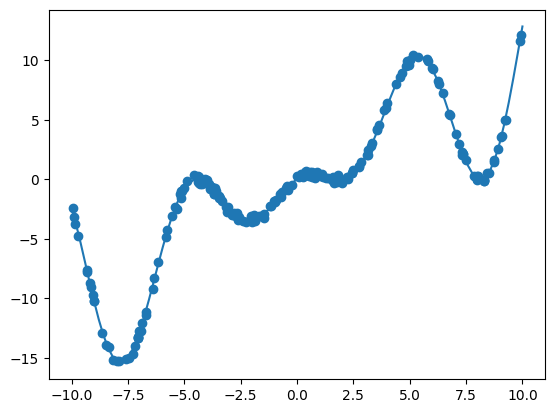

In [12]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2
    # return 3*np.exp(-x) * np.sin(2*np.pi*x)

X = np.linspace(-10,10,100)[:,np.newaxis]
y = oscillator(X) # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data) + np.random.normal(scale=0.2, size=X_data.shape)

plt.plot(X,y)
plt.scatter(X_data, y_data)
plt.show()

In [13]:
# Convert to dataframes
df = pd.DataFrame({'x': X_data, 'y': y_data})

In [14]:
# Send the experimental dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset predict was processed.


In [15]:
# Training parameters
params = {
    "dataset_id": dataset_id,
    "inputs" : ["x"],
    "outputs": ["y"],
    "test_train_ratio": 0.8,
}

In [16]:
# Train model 
tl.train_campaign(params, campaign_id, verbose=True)

Model predict has begun training.


In [ ]:
predict_df = tl.predict_campaign(df, campaign_id, )

In [7]:
# Initialise campaign
setup_dict = {
    'inputs': df.columns[0], 
    'outputs': df.columns[1],
    'estimator': 'gaussian_process_regression',
    'estimator_kwargs': {
        'covar_module': "LIN",
        'detrend': True
    }
}

gp_campaign = tl.Campaign(**setup_dict)

# Perform kernel selection
train_dict = {
    'df': df,
    'train_test_split': 150,
    'model_selection': False,
    'seed': 123
}

gp_campaign.fit(**train_dict)

# Plot inference results
df_mean, df_stdev = gp_campaign.predict(pd.DataFrame(X, columns=gp_campaign.inputs))
y_mean, y_stdev = df_mean[gp_campaign.outputs].values, df_stdev[gp_campaign.outputs].values

AttributeError: module 'twinlab' has no attribute 'Campaign'